# Principal Component Analysis (PCA)

### Lets Prepare Data:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%203/data/Wholesale_Customers_Data.csv', sep=',')

In [3]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
data.shape

(440, 8)

In [5]:
data=data.drop(["Channel","Region"],axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


In [10]:
# Convert to float:
for col in data.columns:
    data[col]=data[col].astype(np.float)

In [11]:
orj_data=data.copy()

## Scale the Data
* Skew
* Scale
* Correlation

In [12]:
corr_matrix=data.corr()

for i in range(corr_matrix.shape[0]):
    corr_matrix.iloc[i,i]=0.0
corr_matrix

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,0.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,0.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,0.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,0.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,0.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,0.000000


In [13]:
corr_matrix.abs().idxmax() # Max correlated features

Fresh                         Frozen
Milk                         Grocery
Grocery             Detergents_Paper
Frozen                    Delicassen
Detergents_Paper             Grocery
Delicassen                      Milk
dtype: object

In [15]:
log_cols=data.skew().sort_values(ascending=False)
log_cols=log_cols.loc[log_cols>.75]
log_cols

Delicassen          11.151586
Frozen               5.907986
Milk                 4.053755
Detergents_Paper     3.631851
Grocery              3.587429
Fresh                2.561323
dtype: float64

In [16]:
for col in log_cols.index:
    data[col]=np.log1p(data[col])

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

for col in data.columns:
    data[col]=scaler.fit_transform(data[[col]]).squeeze()

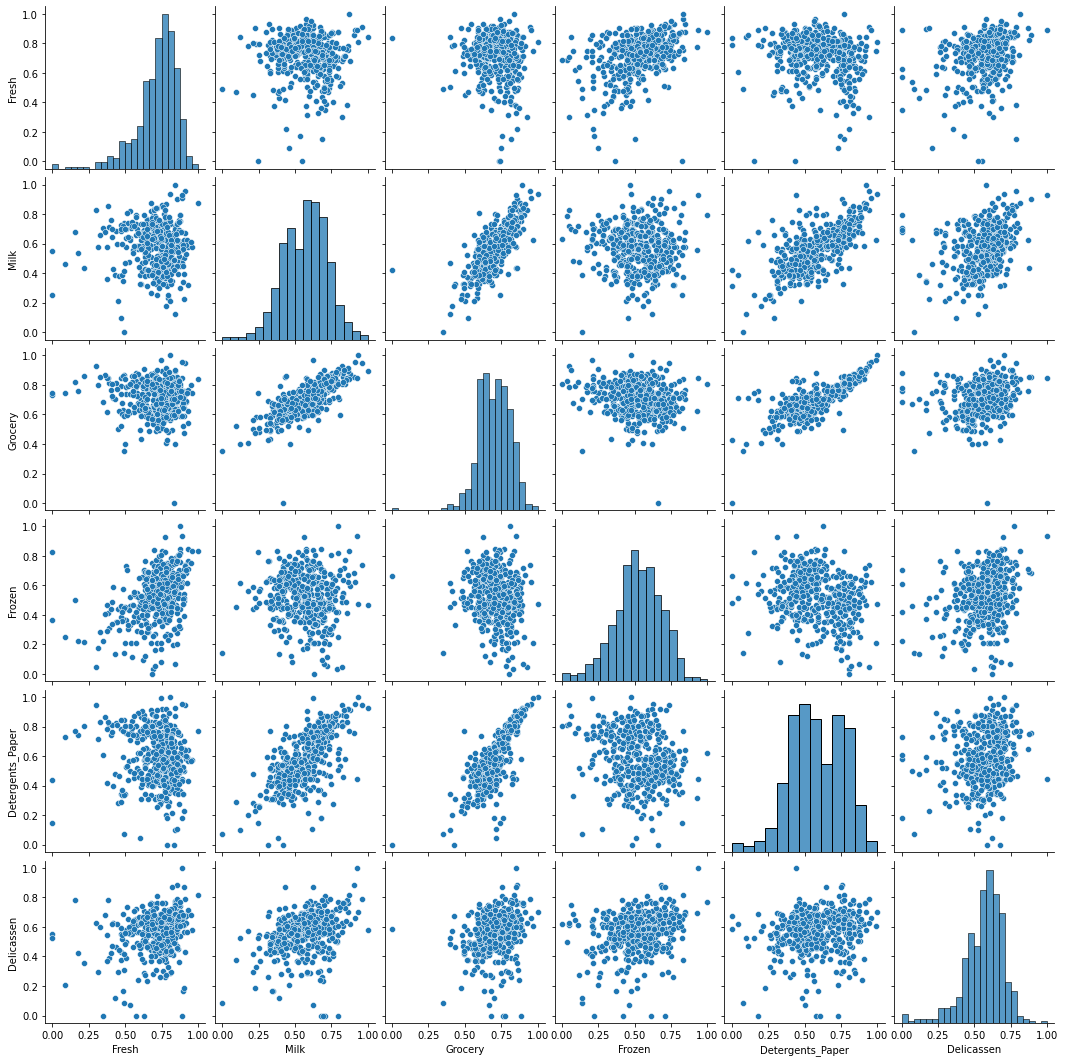

In [18]:
sns.pairplot(data);

### Recreate preprocessing part with sklearn pipline function:

* Scikit-learn has a more flexible Pipeline function and a shortcut version called **make_pipeline**. Either can be used. Also, if different transformations need to be performed on the data, a **FeatureUnion** can be used.

In [19]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

log_transform=FunctionTransformer(np.log1p)

estimators=[("log1p",log_transform),("minmaxscale",MinMaxScaler())]
pipeline=Pipeline(estimators)

data_pipeline=pipeline.fit_transform(orj_data)

In [20]:
np.allclose(data_pipeline,data)

True

# PCA:

In [21]:
from sklearn.decomposition import PCA

pca_list=[]
feature_weight_list=[]

for n in range(1,6):
    pca_model=PCA(n_components=n)
    pca_model.fit(data)
    
    pca_list.append(pd.Series({"n":n,"model":pca_model,"var":pca_model.explained_variance_ratio_.sum()}))
    
    abs_feature_values=np.abs(pca_model.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({"n":n,"features":data.columns,"values":abs_feature_values/abs_feature_values.sum()}))
pca_data=pd.concat(pca_list,axis=1).T.set_index("n")
pca_data

,model,var
n,,
1,PCA(n_components=1),0.448011
2,PCA(n_components=2),0.72099
3,PCA(n_components=3),0.827534
4,PCA(n_components=4),0.923045
5,PCA(n_components=5),0.979574


In [23]:
# Lets create table of feature:
features_data=(pd.concat(feature_weight_list).pivot(index="n",columns="features",values="values"))
features_data

features,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
n,,,,,,
1,0.071668,0.335487,0.060620,0.095979,0.190236,0.246010
2,0.151237,0.177519,0.158168,0.222172,0.112032,0.178872
3,0.165518,0.145815,0.211434,0.268363,0.084903,0.123967
4,0.224259,0.149981,0.239527,0.214275,0.070971,0.100987
5,0.211840,0.182447,0.196382,0.178104,0.067338,0.163888


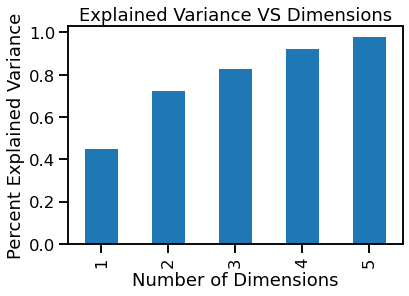

In [26]:
# Plot variance:
sns.set_context("talk")
ax=pca_data["var"].plot(kind="bar")
ax.set(xlabel="Number of Dimensions",
      ylabel="Percent Explained Variance",
      title="Explained Variance VS Dimensions");

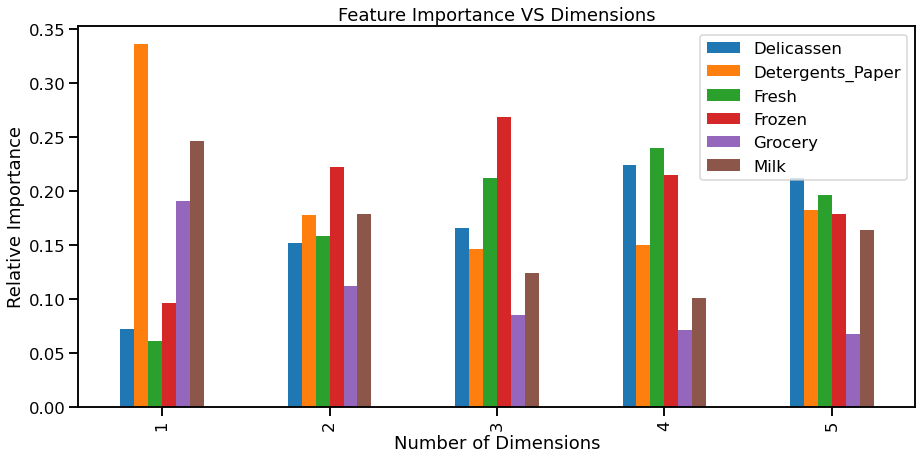

In [27]:
# Plot Importance:
ax=features_data.plot(kind="bar",figsize=(15,7))
ax.legend(loc="upper right")
ax.set(xlabel="Number of Dimensions",
      ylabel="Relative Importance",
      title="Feature Importance VS Dimensions");

# FIT KernelPCA

In [28]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def scorer(pca_Model,X,y=None):
    try:
        X_val=X.values
    except:
        X_val=X
    
    data_inverse=pca_Model.fit(X_val).transform(X_val)
    data_inverse=pca_Model.inverse_transform(data_inverse)
    
    mse=mean_squared_error(data_inverse.ravel(),X_val.ravel())
    return -1.0 * mse

### GridSearch:

In [29]:
params={"gamma":[0.001,0.01,0.05,0.1,0.5,1.0],
       "n_components":[2,3,4]}
kernelPCA=GridSearchCV(KernelPCA(kernel="rbf",fit_inverse_transform=True),param_grid=params,scoring=scorer,n_jobs=-1)
kernelPCA=kernelPCA.fit(data)
kernelPCA.best_estimator_

KernelPCA(fit_inverse_transform=True, gamma=1.0, kernel='rbf', n_components=4)